In [43]:
#Author Jeffrey Tang
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import re
import random
import warnings

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve

warnings.simplefilter("ignore")

In [30]:
#Data Preprocessing
df = pd.read_csv('stack overflow data.csv')
df

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
...,...,...,...,...,...,...
59995,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
59996,60468018,How can I make a c# application outside of vis...,<p>I'm very new to programming and I'm teachin...,<c#><visual-studio>,2020-02-29 17:55:56,LQ_CLOSE
59997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
59998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            60000 non-null  int64 
 1   Title         60000 non-null  object
 2   Body          60000 non-null  object
 3   Tags          60000 non-null  object
 4   CreationDate  60000 non-null  object
 5   Y             60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.7+ MB


In [32]:
#df['Category']=pd.get_dummies(df['Y'])
df2 = pd.get_dummies(df['Y'])
df2
df['Y'] = df['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})

<AxesSubplot:xlabel='HQ', ylabel='count'>

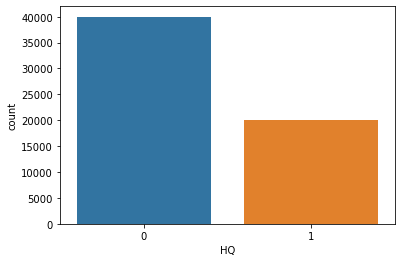

In [33]:
sns.countplot(x='HQ',data=df2)

In [40]:
df['Body'] = df['Title'] + ' ' + df['Body']
df0 = df.drop(['Id', 'Title', 'CreationDate'], axis = 1)

df0

,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds Java: R...,<java><repeat>,0
1,How to get all the child records from differen...,<sql><sql-server>,1
2,Why are Java Optionals immutable? Why are Java...,<java><optional>,2
3,Text Overlay Image with Darkened Opacity React...,<javascript><image><overlay><react-native><opa...,2
4,Why ternary operator in swift is so picky? Why...,<swift><operators><whitespace><ternary-operato...,2
...,...,...,...
59995,C++ The correct way to multiply an integer and...,<c++>,0
59996,How can I make a c# application outside of vis...,<c#><visual-studio>,0
59997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,<django><django-views><django-templates>,1
59998,PHP - getting the content of php page PHP - ge...,<javascript><php><html>,0


In [36]:
def text_processing(message):
    
    Stopwords = stopwords.words('english')
    
    no_punctuation = [char for char in message if char not in string.punctuation]

    no_punctuation = ''.join(no_punctuation)
    
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in Stopwords])

df0['text'] = df['Body'].apply(text_processing)

df0.head()

,Body,Y,text
0,Java: Repeat Task Every Random Seconds <p>I'm ...,0,Java Repeat Task Every Random Seconds pIm alre...
1,How to get all the child records from differen...,1,get child records different tables based given...
2,Why are Java Optionals immutable? <p>I'd like ...,2,Java Optionals immutable pId like understand J...
3,Text Overlay Image with Darkened Opacity React...,2,Text Overlay Image Darkened Opacity React Nati...
4,Why ternary operator in swift is so picky? <p>...,2,ternary operator swift picky pThe question sim...


In [37]:
from sklearn.model_selection import train_test_split
X=df0['text'].values
y=df0['Y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
X_train

array(['Getting Null pointer exception trying add two string elements pI asked following question interview Array 12345 Array b abcde write program add individual elements array enter sum third array output like e1 d2 c3 b4 a5p pI able come solution time trying home wrote following code got null pointer exception p precodepublic class ArrayMergeIndividualElements String 12345 String b abcde String snull void mergeArrays int k0 int jblength1 forint i0iltalengthi forjgt0 SystemoutprintlnNumber array ai SystemoutprintlnString array bj skaibj getting null pointer exception line k j break Systemoutprintlnoutput forint l0lltslengthl Systemoutprintsl public static void mainString args ArrayMergeIndividualElements amie new ArrayMergeIndividualElements amiemergeArrays codepre pI tried following code searching stackoverflow luck String StreamconcatArraysstreamai Arraysstreambj toArrayStringnewp pIndividually arrays printing value try addconcatenate getting null pointerp pAlso add arrays one Inte

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_test

<12000x468818 sparse matrix of type '<class 'numpy.float64'>'
	with 486617 stored elements in Compressed Sparse Row format>

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
model = Sequential()
model.add(Dense(units=8270,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=400,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.fit(x=X_train,y=y_train,epochs=40,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop])

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=  (0, 189358)	0.05785868475958091
  (0, 324463)	0.060827333396160414
  (0, 55406)	0.07219124646941658
  (0, 226446)	0.05622473263721933
  (0, 297840)	0.033507710493137506
  (0, 308645)	0.06803926579987427
  (0, 321721)	0.10529317833341381
  (0, 36652)	0.12442725559185154
  (0, 435763)	0.0404007212620033
  (0, 448244)	0.03632213895997637
  (0, 336794)	0.06771180037217676
  (0, 55497)	0.12381361506802752
  (0, 318121)	0.12442725559185154
  (0, 431253)	0.12442725559185154
  (0, 55628)	0.12442725559185154
  (0, 401890)	0.12442725559185154
  (0, 260861)	0.07367474126231686
  (0, 397321)	0.07166910623223174
  (0, 374470)	0.06417339535946695
  (0, 435130)	0.03609687183380289
  (0, 99434)	0.021735418779530898
  (0, 42337)	0.12442725559185154
  (0, 284956)	0.02973333849358954
  (0, 42336)	0.12442725559185154
  (0, 53773)	0.053125400369478264
  :	:
  (47999, 321830)	0.17997184512103825
  (47999, 254391)	0.17338936063252694
  (47999, 242752)	0.1574661820045265
  (47999, 344564)	0.3192679692342787
  (47999, 276411)	0.31110808917151955
  (47999, 263266)	0.3467787212650539
  (47999, 242766)	0.2851814956412658
  (47999, 263404)	0.1538435793788888
  (47999, 182472)	0.0759198307033088
  (47999, 367321)	0.19567017356291108
  (47999, 325060)	0.0561471581645035
  (47999, 263245)	0.08543816388333926
  (47999, 225600)	0.06894571264637162
  (47999, 43331)	0.0631866412455483
  (47999, 50710)	0.05813358144678109
  (47999, 189239)	0.04608314055696306
  (47999, 455670)	0.03840566377028035
  (47999, 384504)	0.06706742613200724
  (47999, 445947)	0.03729674158319997
  (47999, 324463)	0.08798078341459817
  (47999, 99434)	0.03143815560042629
  (47999, 284956)	0.08601272711266224
  (47999, 317567)	0.03137185573210078
  (47999, 436925)	0.05809342486767915
  (47999, 36443)	0.05914265482254197